In [1]:
from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np

%matplotlib inline

from torch import autograd
from torch.autograd import Variable
from tensorboardX import SummaryWriter
import torch.optim as optim
import torchvision.datasets as datasets
import time
import os

if __name__ == "__main__":
    print("Torch version:", torch.__version__)
    print("CUDA available:", torch.cuda.is_available())
    print("CUDA version:", torch.version.cuda)
    print("Number of GPUs:", torch.cuda.device_count())
    print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.device_count() > 0 else "No GPU detected")

Torch version: 2.7.0+cu126
CUDA available: True
CUDA version: 12.6
Number of GPUs: 1
GPU name: NVIDIA GeForce RTX 4090


In [2]:

def plot_shape(shape_matrix):
    """Plot the generated shape (expects input shape (1, 32, 32) or (32, 32))."""
    # Squeeze channel if present
    if shape_matrix.ndim == 3 and shape_matrix.shape[0] == 1:
        shape_matrix = shape_matrix.squeeze(0)  # → (32, 32)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.set_facecolor('#301934')
    ax.imshow(shape_matrix, origin='upper', cmap='viridis')  # add colormap if needed
    plt.axis('off')
    # print(f'size: {shape_matrix.shape[0]} x {shape_matrix.shape[1]}')
    plt.show()


def load_item(item, p= True, action=''):
    if action=='':
        if p:
            print(f'Eigenmodes: {item[0]}')
            print(f'Weights: {item[1]}')
            print(f'Params: {item[2]}')
        plot_shape(item[3])
        return {'Eigenmodes':item[0], 'Weights':item[1], 'Params':item[2]}
    if action == 'shape':
        return item[3]
    
def quarter(matrix):
    return matrix[:32, :32]

Eigenmodes: tensor([4.9921, 1.5929, 0.5911, 0.0000])
Weights: tensor([7.7262e+01, 1.4055e+01, 8.6509e+00, 2.6938e-05])
Params: tensor([1.3050, 0.6800, 3.3900, 7.9300])


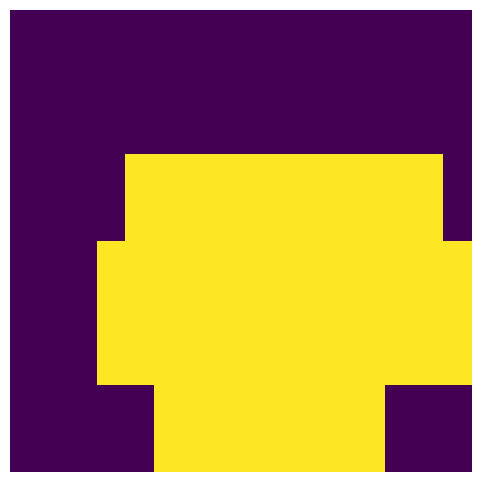

torch.Size([1098910, 1, 32, 32])


In [3]:
import h5py
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
%matplotlib inline

class WaveguideDataset(Dataset):
    def __init__(self, h5_file):
        self.h5_file = h5py.File(h5_file, 'r')
        weights = self.h5_file['weight_train'][:]  # Shape: (N, 4)
        weight_sums = np.sum(weights, axis=1)  # Shape: (N,)
        patterns = self.h5_file['pattern_train'][:] # Shape: (N, 64, 64)
        mask = weight_sums < 100 # Mask that sorts for just good data 

        self.eigenmodes = torch.tensor(self.h5_file['neff_train'][:][mask], dtype=torch.float32)   # (N, 4)
        self.weights = torch.tensor(weights[mask], dtype=torch.float32)                            # (N, 4)
        self.paramss = torch.tensor(self.h5_file['params_train'][:][mask], dtype=torch.float32)    # (N, 4)
        self.waveguides = torch.tensor(np.array([quarter(p) for p in patterns])[mask], dtype=torch.float32).unsqueeze(1)  # (N, 32, 32)

    def __len__(self):
        return len(self.waveguides)

    def __getitem__(self, idx):
        eigenmode = self.eigenmodes[idx]  # (10, H, W)
        weight = self.weights[idx]  # (10,)
        params = self.paramss[idx]
        waveguide = self.waveguides[idx]  # (1, H, W)

        return eigenmode, weight, params, waveguide

dataset = WaveguideDataset('train_test_split.h5')
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
# print(dataloader)
if __name__ == "__main__":
    load_item(dataset.__getitem__(2))
    print(dataset.waveguides.shape)



In [5]:

class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        '''
        standard ResNet style convolutional block
        '''
        self.same_channels = in_channels==out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            # this adds on correct residual in case channels have increased
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2 
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2


In [6]:
class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        '''
        process and downscale the image feature maps
        '''
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


In [24]:
class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        self.model = nn.Sequential(
            ResidualConvBlock(in_channels, out_channels, is_res=True),
            ResidualConvBlock(out_channels, out_channels, is_res=True),
        )

    def forward(self, x, skip):
        # crop the skip connection if needed to match x
        if skip.shape[2:] != x.shape[2:]:
            diffY = skip.size()[2] - x.size()[2]
            diffX = skip.size()[3] - x.size()[3]
            skip = skip[:, :, diffY // 2: skip.size(2) - (diffY - diffY // 2),
                              diffX // 2: skip.size(3) - (diffX - diffX // 2)]

        x = torch.cat((x, skip), dim=1)
        return self.model(x)




In [8]:
class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        generic one layer FC NN for embedding things  
        '''
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)




In [ ]:
class ContextUnet_bad(nn.Module):
    def __init__(self, in_channels, n_feat = 256, n_classes=10):
        super(ContextUnet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes

        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_classes, 2*n_feat)
        self.contextembed2 = EmbedFC(n_classes, 1*n_feat)

        self.up0 = nn.Sequential(
            # nn.ConvTranspose2d(6 * n_feat, 2 * n_feat, 7, 7), # when concat temb and cemb end up w 6*n_feat
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 7, 7), # otherwise just have 2*n_feat
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, c, t, context_mask):
        # x is (noisy) image, c is context label, t is timestep, 
        # context_mask says which samples to block the context on

        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)

        # convert context to one hot embedding
        c = nn.functional.one_hot(c, num_classes=self.n_classes).type(torch.float)
        
        # mask out context if context_mask == 1
        context_mask = context_mask[:, None]
        context_mask = context_mask.repeat(1,self.n_classes)
        context_mask = (-1*(1-context_mask)) # need to flip 0 <-> 1
        c = c * context_mask
        
        # embed context, time step
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)

        # could concatenate the context embedding here instead of adaGN
        # hiddenvec = torch.cat((hiddenvec, temb1, cemb1), 1)

        up1 = self.up0(hiddenvec)
        # up2 = self.up1(up1, down2) # if want to avoid add and multiply embeddings
        up2 = self.up1(cemb1*up1+ temb1, down2)  # add and multiply embeddings
        up3 = self.up2(cemb2*up2+ temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out




In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat=256, cond_dim=8):
        super(ContextUnet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.cond_dim = cond_dim

        # Initial convolution
        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        # Downsampling path
        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)

        # Bottleneck vector (no spatial dims)
        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

        # Conditioning and timestep embeddings
        self.timeembed1 = EmbedFC(1, 2 * n_feat)
        self.timeembed2 = EmbedFC(1, 1 * n_feat)
        self.contextembed1 = EmbedFC(cond_dim, 2 * n_feat)
        self.contextembed2 = EmbedFC(cond_dim, 1 * n_feat)

        # Decoder path
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 7, 7),  # (B, 2n, 7, 7)
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )
        self.up1 = UnetUp(4 * n_feat, n_feat)  # with skip from down2
        self.up2 = UnetUp(2 * n_feat, n_feat)  # with skip from down1

        # Final upsampling to (32x32) via learned transpose convolutions
        self.up3 = nn.Sequential(
            nn.ConvTranspose2d(n_feat, n_feat, kernel_size=4, stride=2, padding=1),  # 7 → 14
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.ConvTranspose2d(n_feat, n_feat, kernel_size=4, stride=2, padding=1),  # 14 → 28
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, kernel_size=3, stride=1, padding=2),  # 28 → 32
        )

    def forward(self, x, c, t, context_mask):
        """
        x:        (B, 1, 32, 32) - noisy waveguide
        c:        (B, 8) - conditioning vector (eigenmodes + weights)
        t:        (B,) - diffusion timestep (normalized)
        context_mask: (B,) - binary mask for classifier-free guidance
        """
        # Downsample
        x_init = self.init_conv(x)
        down1 = self.down1(x_init)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)

        # Apply context mask (0 = keep, 1 = drop)
        context_mask = context_mask[:, None]  # (B, 1)
        c = c * (1 - context_mask)

        # Embeddings
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)

        # Decoder
        up1 = self.up0(hiddenvec)                      # (B, 2n, 7, 7)
        up2 = self.up1(cemb1 * up1 + temb1, down2)     # (B, n, 7, 7)
        up3 = self.up2(cemb2 * up2 + temb2, down1)     # (B, n, 7, 7)
        out = self.up3(up3)
        return F.interpolate(out, size=(32, 32), mode='bilinear', align_corners=False)



In [10]:
def ddpm_schedules(beta1, beta2, T):
    """
    Returns pre-computed schedules for DDPM sampling, training process.
    """
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {
        "alpha_t": alpha_t,  # \alpha_t
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t}
        "alphabar_t": alphabar_t,  # \bar{\alpha_t}
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}
    }




In [ ]:
class DDPM_bad(nn.Module):
    def __init__(self, nn_model, betas, n_T, device, drop_prob=0.1):
        super(DDPM, self).__init__()
        self.nn_model = nn_model.to(device)

        # register_buffer allows accessing dictionary produced by ddpm_schedules
        # e.g. can access self.sqrtab later
        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.device = device
        self.drop_prob = drop_prob
        self.loss_mse = nn.MSELoss()

    def forward(self, x, c):
        """
        this method is used in training, so samples t and noise randomly
        """

        _ts = torch.randint(1, self.n_T+1, (x.shape[0],)).to(self.device)  # t ~ Uniform(0, n_T)
        noise = torch.randn_like(x)  # eps ~ N(0, 1)

        x_t = (
            self.sqrtab[_ts, None, None, None] * x
            + self.sqrtmab[_ts, None, None, None] * noise
        )  # This is the x_t, which is sqrt(alphabar) x_0 + sqrt(1-alphabar) * eps
        # We should predict the "error term" from this x_t. Loss is what we return.

        # dropout context with some probability
        context_mask = torch.bernoulli(torch.zeros_like(c)+self.drop_prob).to(self.device)
        
        # return MSE between added noise, and our predicted noise
        return self.loss_mse(noise, self.nn_model(x_t, c, _ts / self.n_T, context_mask))

    def sample(self, n_sample, size, device, guide_w = 0.0):
        # we follow the guidance sampling scheme described in 'Classifier-Free Diffusion Guidance'
        # to make the fwd passes efficient, we concat two versions of the dataset,
        # one with context_mask=0 and the other context_mask=1
        # we then mix the outputs with the guidance scale, w
        # where w>0 means more guidance

        x_i = torch.randn(n_sample, *size).to(device)  # x_T ~ N(0, 1), sample initial noise
        c_i = torch.arange(0,10).to(device) # context for us just cycles throught the mnist labels
        c_i = c_i.repeat(int(n_sample/c_i.shape[0]))

        # don't drop context at test time
        context_mask = torch.zeros_like(c_i).to(device)

        # double the batch
        c_i = c_i.repeat(2)
        context_mask = context_mask.repeat(2)
        context_mask[n_sample:] = 1. # makes second half of batch context free

        x_i_store = [] # keep track of generated steps in case want to plot something 
        print()
        for i in range(self.n_T, 0, -1):
            print(f'sampling timestep {i}',end='\r')
            t_is = torch.tensor([i / self.n_T]).to(device)
            t_is = t_is.repeat(n_sample,1,1,1)

            # double batch
            x_i = x_i.repeat(2,1,1,1)
            t_is = t_is.repeat(2,1,1,1)

            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0

            # split predictions and compute weighting
            eps = self.nn_model(x_i, c_i, t_is, context_mask)
            eps1 = eps[:n_sample]
            eps2 = eps[n_sample:]
            eps = (1+guide_w)*eps1 - guide_w*eps2
            x_i = x_i[:n_sample]
            x_i = (
                self.oneover_sqrta[i] * (x_i - eps * self.mab_over_sqrtmab[i])
                + self.sqrt_beta_t[i] * z
            )
            if i%20==0 or i==self.n_T or i<8:
                x_i_store.append(x_i.detach().cpu().numpy())
        
        x_i_store = np.array(x_i_store)
        return x_i, x_i_store


In [18]:
class DDPM(nn.Module):
    def __init__(self, nn_model, betas, n_T, device, drop_prob=0.1):
        super(DDPM, self).__init__()
        self.nn_model = nn_model.to(device)

        # Precomputed noise schedule buffers
        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.device = device
        self.drop_prob = drop_prob
        self.loss_mse = nn.MSELoss()

    def forward(self, x, c):
        """
        Training forward pass.

        x: (B, 1, 32, 32) - real waveguide
        c: (B, 8) - conditioning vector (eigenmodes + weights)
        """
        B = x.shape[0]
        t = torch.randint(1, self.n_T + 1, (B,), device=self.device)
        noise = torch.randn_like(x)

        # Forward diffusion step
        x_t = (
            self.sqrtab[t, None, None, None] * x +
            self.sqrtmab[t, None, None, None] * noise
        )

        # Randomly drop context for classifier-free guidance
        context_mask = torch.bernoulli(torch.full((B,), self.drop_prob)).to(self.device)
        t_norm = t / self.n_T

        # Predict noise using model
        pred_noise = self.nn_model(x_t, c, t_norm, context_mask)
        return self.loss_mse(noise, pred_noise)

    def sample(self, n_sample, size, device, guide_w=0.0, cond=None):
        """
        Generate samples with classifier-free guidance.
        
        cond: (n_sample, 8) - condition vectors
        Returns:
            x_i: final image tensor (n_sample, 1, 32, 32)
            x_i_store: intermediate images for animation
        """
        assert cond is not None and cond.shape[0] == n_sample, \
            "Must provide `cond` tensor of shape (n_sample, 8)"

        # Initial noise
        x_i = torch.randn(n_sample, *size).to(device)

        # Duplicate conditioning vector for guided/unconditioned
        c_i = cond.to(device)
        c_i_full = c_i.repeat(2, 1)  # (2 * n_sample, 8)

        # Create context masks: first half uses context, second half masks it out
        context_mask = torch.zeros(n_sample, device=device)
        context_mask = context_mask.repeat(2)
        context_mask[n_sample:] = 1

        x_i_store = []

        for i in range(self.n_T, 0, -1):
            print(f"sampling timestep {i}", end="\r")

            t = torch.full((n_sample,), i / self.n_T, device=device)
            t_full = t.repeat(2)  # (2 * n_sample,)

            # Duplicate x_i manually (don't mutate x_i!)
            x_i_full = x_i.repeat(2, 1, 1, 1)  # (2 * n_sample, 1, 32, 32)

            # Predict noise with masked/unmasked context
            eps = self.nn_model(x_i_full, c_i_full, t_full, context_mask)
            eps1, eps2 = eps.chunk(2, dim=0)  # separate guided and unguided
            eps_guided = (1 + guide_w) * eps1 - guide_w * eps2

            z = torch.randn_like(x_i) if i > 1 else 0

            x_i = (
                self.oneover_sqrta[i] * (x_i - eps_guided * self.mab_over_sqrtmab[i])
                + self.sqrt_beta_t[i] * z
            )

            if i % 20 == 0 or i == self.n_T or i < 8:
                x_i_store.append(x_i.detach().cpu().numpy())

        return x_i, np.array(x_i_store)

In [12]:
import os
def train_mnist():

    # hardcoding these here
    n_epoch = 20
    batch_size = 256
    n_T = 400 # 500
    device = "cuda:0"
    n_classes = 10
    n_feat = 128 # 128 ok, 256 better (but slower)
    lrate = 1e-4
    save_model = False
    save_dir = './data/diffusion_outputs10/'
    os.makedirs(save_dir, exist_ok=True)
    ws_test = [0.0, 0.5, 2.0] # strength of generative guidance

    ddpm = DDPM(nn_model=ContextUnet(in_channels=1, n_feat=n_feat, n_classes=n_classes), betas=(1e-4, 0.02), n_T=n_T, device=device, drop_prob=0.1)
    ddpm.to(device)

    # optionally load a model
    # ddpm.load_state_dict(torch.load("./data/diffusion_outputs/ddpm_unet01_mnist_9.pth"))

    tf = transforms.Compose([transforms.ToTensor()]) # mnist is already normalised 0 to 1

    dataset = MNIST("./data", train=True, download=True, transform=tf)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=5)
    optim = torch.optim.Adam(ddpm.parameters(), lr=lrate)

    for ep in range(n_epoch):
        print(f'epoch {ep}')
        ddpm.train()

        # linear lrate decay
        optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)

        pbar = tqdm(dataloader)
        loss_ema = None
        for x, c in pbar:
            optim.zero_grad()
            x = x.to(device)
            c = c.to(device)
            loss = ddpm(x, c)
            loss.backward()
            if loss_ema is None:
                loss_ema = loss.item()
            else:
                loss_ema = 0.95 * loss_ema + 0.05 * loss.item()
            pbar.set_description(f"loss: {loss_ema:.4f}")
            optim.step()
        
        # for eval, save an image of currently generated samples (top rows)
        # followed by real images (bottom rows)
        ddpm.eval()
        with torch.no_grad():
            n_sample = 4*n_classes
            for w_i, w in enumerate(ws_test):
                x_gen, x_gen_store = ddpm.sample(n_sample, (1, 28, 28), device, guide_w=w)

                # append some real images at bottom, order by class also
                x_real = torch.Tensor(x_gen.shape).to(device)
                for k in range(n_classes):
                    for j in range(int(n_sample/n_classes)):
                        try: 
                            idx = torch.squeeze((c == k).nonzero())[j]
                        except:
                            idx = 0
                        x_real[k+(j*n_classes)] = x[idx]

                x_all = torch.cat([x_gen, x_real])
                grid = make_grid(x_all*-1 + 1, nrow=10)
                save_image(grid, save_dir + f"image_ep{ep}_w{w}.png")
                print('saved image at ' + save_dir + f"image_ep{ep}_w{w}.png")

                if ep%5==0 or ep == int(n_epoch-1):
                    # create gif of images evolving over time, based on x_gen_store
                    fig, axs = plt.subplots(nrows=int(n_sample/n_classes), ncols=n_classes,sharex=True,sharey=True,figsize=(8,3))
                    def animate_diff(i, x_gen_store):
                        print(f'gif animating frame {i} of {x_gen_store.shape[0]}', end='\r')
                        plots = []
                        for row in range(int(n_sample/n_classes)):
                            for col in range(n_classes):
                                axs[row, col].clear()
                                axs[row, col].set_xticks([])
                                axs[row, col].set_yticks([])
                                # plots.append(axs[row, col].imshow(x_gen_store[i,(row*n_classes)+col,0],cmap='gray'))
                                plots.append(axs[row, col].imshow(-x_gen_store[i,(row*n_classes)+col,0],cmap='gray',vmin=(-x_gen_store[i]).min(), vmax=(-x_gen_store[i]).max()))
                        return plots
                    ani = FuncAnimation(fig, animate_diff, fargs=[x_gen_store],  interval=200, blit=False, repeat=True, frames=x_gen_store.shape[0])    
                    ani.save(save_dir + f"gif_ep{ep}_w{w}.gif", dpi=100, writer=PillowWriter(fps=5))
                    print('saved image at ' + save_dir + f"gif_ep{ep}_w{w}.gif")
        # optionally save model
        if save_model and ep == int(n_epoch-1):
            torch.save(ddpm.state_dict(), save_dir + f"model_{ep}.pth")
            print('saved model at ' + save_dir + f"model_{ep}.pth")


In [41]:
def train_waveguide_diffusion(dataset):
    # Hyperparameters
    n_epoch = 20
    batch_size = 32
    n_T = 400
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    n_feat = 128
    lrate = 1e-4
    save_model = True
    save_dir = './data/waveguide_diffusion_outputs/'
    guide_weights = [0.0, 0.5, 2.0]

    os.makedirs(save_dir, exist_ok=True)

    model = ContextUnet(in_channels=1, n_feat=n_feat, cond_dim=8)
    ddpm = DDPM(nn_model=model, betas=(1e-4, 0.02), n_T=n_T, device=device, drop_prob=0.1)
    ddpm.to(device)

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optim = torch.optim.Adam(ddpm.parameters(), lr=lrate)

    # Take first 10 mode-weight conditionings from dataset
    cond_list = []
    for i in range(10):
        eigenmode, weight, _, _ = dataset[i]
        cond_list.append(torch.cat([eigenmode, weight]))
    cond_tensor = torch.stack(cond_list).to(device)

    for ep in range(n_epoch):
        print(f"\nEpoch {ep}")
        ddpm.train()
        optim.param_groups[0]['lr'] = lrate * (1 - ep / n_epoch)
        loss_ema = None

        for eigenmode, weight, _, waveguide in tqdm(dataloader):
            x = waveguide.to(device)
            c = torch.cat([eigenmode, weight], dim=1).to(device)

            loss = ddpm(x, c)
            optim.zero_grad()
            loss.backward()
            optim.step()

            if loss_ema is None:
                loss_ema = loss.item()
            else:
                loss_ema = 0.95 * loss_ema + 0.05 * loss.item()

        # --- Sampling and Visualization ---
        ddpm.eval()
        with torch.no_grad():
            for w in guide_weights:
                x_gen, x_gen_store = ddpm.sample(n_sample=10, size=(1, 32, 32), device=device, guide_w=w, cond=cond_tensor)

                grid = make_grid(x_gen * -1 + 1, nrow=5)
                save_path = os.path.join(save_dir, f"image_ep{ep}_w{w}.png")
                save_image(grid, save_path)
                print(f"Saved image at {save_path}")

                if ep % 5 == 0 or ep == n_epoch - 1:
                    fig, axs = plt.subplots(2, 5, figsize=(10, 4), sharex=True, sharey=True)

                    def animate_diff(i):
                        for idx in range(10):
                            ax = axs[idx // 5][idx % 5]
                            ax.clear()
                            ax.imshow(-x_gen_store[i, idx, 0], cmap='gray')
                            ax.set_xticks([])
                            ax.set_yticks([])

                    ani = FuncAnimation(fig, animate_diff, frames=x_gen_store.shape[0], interval=200)
                    gif_path = os.path.join(save_dir, f"gif_ep{ep}_w{w}.gif")
                    ani.save(gif_path, dpi=100, writer=PillowWriter(fps=5))
                    print(f"Saved GIF at {gif_path}")

        if save_model and ep == n_epoch - 1:
            model_path = os.path.join(save_dir, f"model_ep{ep}.pth")
            torch.save(ddpm.state_dict(), model_path)
            print(f"Saved model at {model_path}")


epoch 0


loss: 0.0483: 100%|██████████| 235/235 [00:20<00:00, 11.21it/s]



saved image at ./data/diffusion_outputs10/image_ep0_w0.0.png
saved image at ./data/diffusion_outputs10/gif_ep0_w0.0.gif

saved image at ./data/diffusion_outputs10/image_ep0_w0.5.png
saved image at ./data/diffusion_outputs10/gif_ep0_w0.5.gif

saved image at ./data/diffusion_outputs10/image_ep0_w2.0.png
saved image at ./data/diffusion_outputs10/gif_ep0_w2.0.gif
epoch 1


loss: 0.0378: 100%|██████████| 235/235 [00:20<00:00, 11.55it/s]



saved image at ./data/diffusion_outputs10/image_ep1_w0.0.png

saved image at ./data/diffusion_outputs10/image_ep1_w0.5.png

saved image at ./data/diffusion_outputs10/image_ep1_w2.0.png
epoch 2


loss: 0.0346: 100%|██████████| 235/235 [00:20<00:00, 11.32it/s]



saved image at ./data/diffusion_outputs10/image_ep2_w0.0.png

saved image at ./data/diffusion_outputs10/image_ep2_w0.5.png

saved image at ./data/diffusion_outputs10/image_ep2_w2.0.png
epoch 3


loss: 0.0329: 100%|██████████| 235/235 [00:20<00:00, 11.32it/s]



saved image at ./data/diffusion_outputs10/image_ep3_w0.0.png

saved image at ./data/diffusion_outputs10/image_ep3_w0.5.png

saved image at ./data/diffusion_outputs10/image_ep3_w2.0.png
epoch 4


loss: 0.0313: 100%|██████████| 235/235 [00:20<00:00, 11.31it/s]



saved image at ./data/diffusion_outputs10/image_ep4_w0.0.png

saved image at ./data/diffusion_outputs10/image_ep4_w0.5.png

saved image at ./data/diffusion_outputs10/image_ep4_w2.0.png
epoch 5


loss: 0.0297: 100%|██████████| 235/235 [00:20<00:00, 11.68it/s]



saved image at ./data/diffusion_outputs10/image_ep5_w0.0.png
saved image at ./data/diffusion_outputs10/gif_ep5_w0.0.gif

saved image at ./data/diffusion_outputs10/image_ep5_w0.5.png
saved image at ./data/diffusion_outputs10/gif_ep5_w0.5.gif

saved image at ./data/diffusion_outputs10/image_ep5_w2.0.png
saved image at ./data/diffusion_outputs10/gif_ep5_w2.0.gif
epoch 6


loss: 0.0289: 100%|██████████| 235/235 [00:20<00:00, 11.28it/s]



saved image at ./data/diffusion_outputs10/image_ep6_w0.0.png

saved image at ./data/diffusion_outputs10/image_ep6_w0.5.png

saved image at ./data/diffusion_outputs10/image_ep6_w2.0.png
epoch 7


loss: 0.0287: 100%|██████████| 235/235 [00:20<00:00, 11.62it/s]



saved image at ./data/diffusion_outputs10/image_ep7_w0.0.png

saved image at ./data/diffusion_outputs10/image_ep7_w0.5.png

saved image at ./data/diffusion_outputs10/image_ep7_w2.0.png
epoch 8


loss: 0.0285: 100%|██████████| 235/235 [00:20<00:00, 11.69it/s]



saved image at ./data/diffusion_outputs10/image_ep8_w0.0.png

saved image at ./data/diffusion_outputs10/image_ep8_w0.5.png

saved image at ./data/diffusion_outputs10/image_ep8_w2.0.png
epoch 9


loss: 0.0276: 100%|██████████| 235/235 [00:20<00:00, 11.62it/s]



saved image at ./data/diffusion_outputs10/image_ep9_w0.0.png

saved image at ./data/diffusion_outputs10/image_ep9_w0.5.png

saved image at ./data/diffusion_outputs10/image_ep9_w2.0.png
epoch 10


loss: 0.0262: 100%|██████████| 235/235 [00:20<00:00, 11.60it/s]



saved image at ./data/diffusion_outputs10/image_ep10_w0.0.png
saved image at ./data/diffusion_outputs10/gif_ep10_w0.0.gif

saved image at ./data/diffusion_outputs10/image_ep10_w0.5.png
saved image at ./data/diffusion_outputs10/gif_ep10_w0.5.gif

saved image at ./data/diffusion_outputs10/image_ep10_w2.0.png
saved image at ./data/diffusion_outputs10/gif_ep10_w2.0.gif
epoch 11


loss: 0.0262: 100%|██████████| 235/235 [00:20<00:00, 11.53it/s]



saved image at ./data/diffusion_outputs10/image_ep11_w0.0.png

saved image at ./data/diffusion_outputs10/image_ep11_w0.5.png

saved image at ./data/diffusion_outputs10/image_ep11_w2.0.png
epoch 12


loss: 0.0256: 100%|██████████| 235/235 [00:20<00:00, 11.63it/s]



saved image at ./data/diffusion_outputs10/image_ep12_w0.0.png

saved image at ./data/diffusion_outputs10/image_ep12_w0.5.png

saved image at ./data/diffusion_outputs10/image_ep12_w2.0.png
epoch 13


loss: 0.0256: 100%|██████████| 235/235 [00:20<00:00, 11.56it/s]



saved image at ./data/diffusion_outputs10/image_ep13_w0.0.png

saved image at ./data/diffusion_outputs10/image_ep13_w0.5.png

saved image at ./data/diffusion_outputs10/image_ep13_w2.0.png
epoch 14


loss: 0.0256: 100%|██████████| 235/235 [00:20<00:00, 11.23it/s]



saved image at ./data/diffusion_outputs10/image_ep14_w0.0.png

saved image at ./data/diffusion_outputs10/image_ep14_w0.5.png

saved image at ./data/diffusion_outputs10/image_ep14_w2.0.png
epoch 15


loss: 0.0254: 100%|██████████| 235/235 [00:21<00:00, 11.17it/s]



saved image at ./data/diffusion_outputs10/image_ep15_w0.0.png
saved image at ./data/diffusion_outputs10/gif_ep15_w0.0.gif

saved image at ./data/diffusion_outputs10/image_ep15_w0.5.png
saved image at ./data/diffusion_outputs10/gif_ep15_w0.5.gif

saved image at ./data/diffusion_outputs10/image_ep15_w2.0.png
saved image at ./data/diffusion_outputs10/gif_ep15_w2.0.gif
epoch 16


loss: 0.0256: 100%|██████████| 235/235 [00:19<00:00, 11.76it/s]



saved image at ./data/diffusion_outputs10/image_ep16_w0.0.png

saved image at ./data/diffusion_outputs10/image_ep16_w0.5.png

saved image at ./data/diffusion_outputs10/image_ep16_w2.0.png
epoch 17


loss: 0.0242: 100%|██████████| 235/235 [00:19<00:00, 12.11it/s]



saved image at ./data/diffusion_outputs10/image_ep17_w0.0.png

saved image at ./data/diffusion_outputs10/image_ep17_w0.5.png

saved image at ./data/diffusion_outputs10/image_ep17_w2.0.png
epoch 18


loss: 0.0252: 100%|██████████| 235/235 [00:20<00:00, 11.59it/s]



saved image at ./data/diffusion_outputs10/image_ep18_w0.0.png

saved image at ./data/diffusion_outputs10/image_ep18_w0.5.png

saved image at ./data/diffusion_outputs10/image_ep18_w2.0.png
epoch 19


loss: 0.0251: 100%|██████████| 235/235 [00:20<00:00, 11.65it/s]



saved image at ./data/diffusion_outputs10/image_ep19_w0.0.png
saved image at ./data/diffusion_outputs10/gif_ep19_w0.0.gif

saved image at ./data/diffusion_outputs10/image_ep19_w0.5.png
saved image at ./data/diffusion_outputs10/gif_ep19_w0.5.gif

saved image at ./data/diffusion_outputs10/image_ep19_w2.0.png
saved image at ./data/diffusion_outputs10/gif_ep19_w2.0.gif


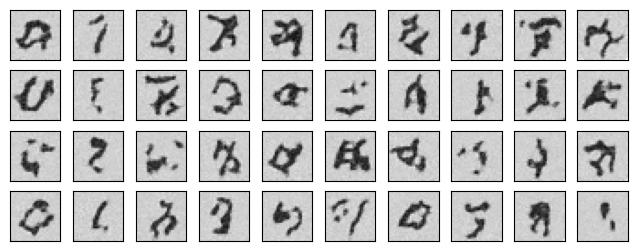

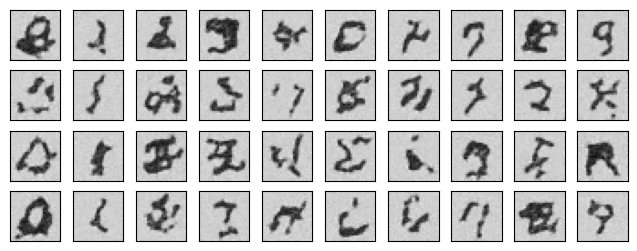

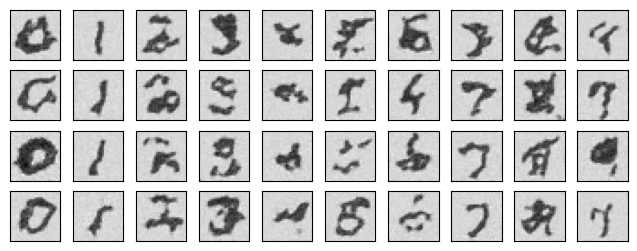

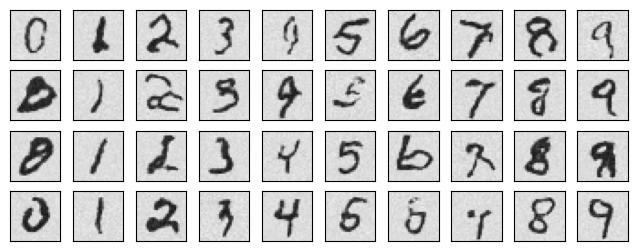

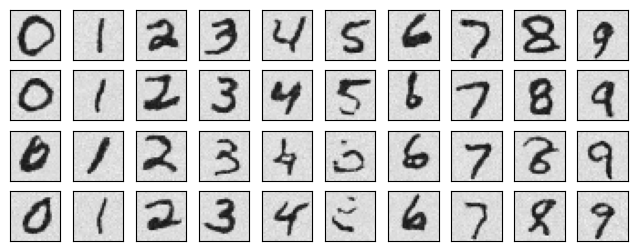

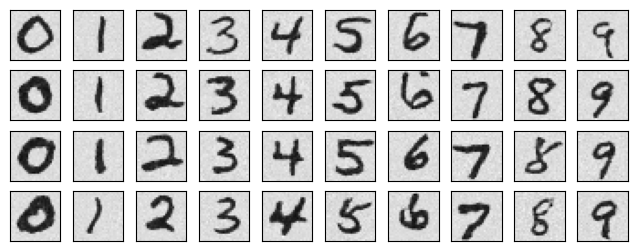

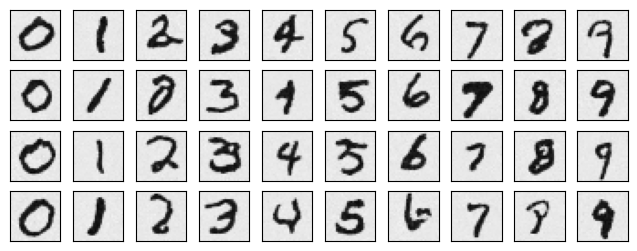

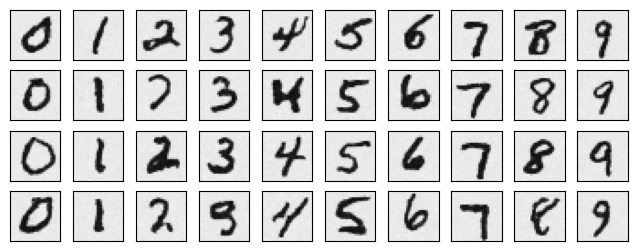

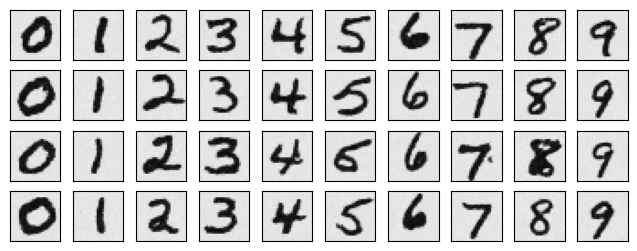

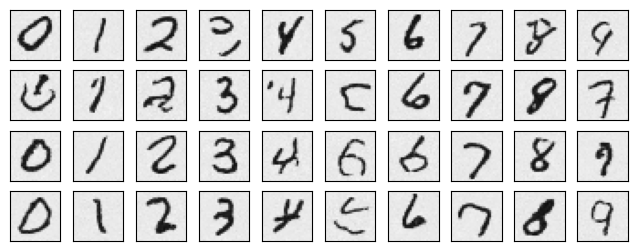

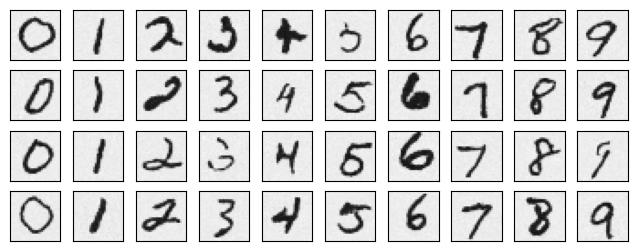

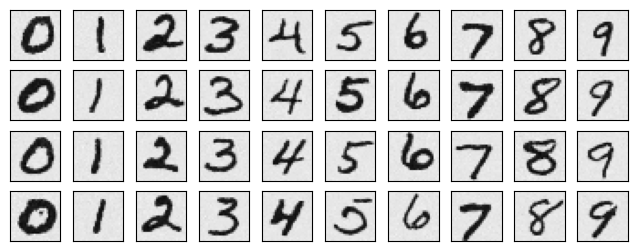

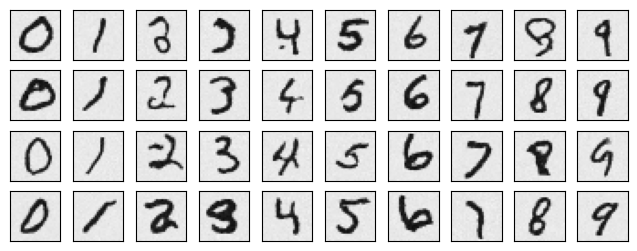

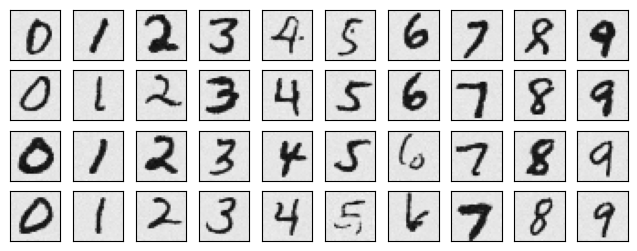

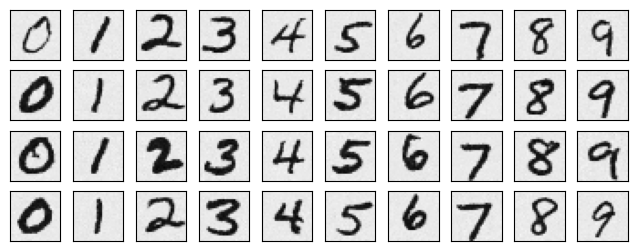

In [ ]:
if __name__ == "__main__":
    train_mnist()


Epoch 0


100%|██████████| 34341/34341 [05:03<00:00, 113.24it/s]


Saved image at ./data/waveguide_diffusion_outputs/image_ep0_w0.0.png
Saved GIF at ./data/waveguide_diffusion_outputs/gif_ep0_w0.0.gif
Saved image at ./data/waveguide_diffusion_outputs/image_ep0_w0.5.png
Saved GIF at ./data/waveguide_diffusion_outputs/gif_ep0_w0.5.gif
Saved image at ./data/waveguide_diffusion_outputs/image_ep0_w2.0.png
Saved GIF at ./data/waveguide_diffusion_outputs/gif_ep0_w2.0.gif

Epoch 1


100%|██████████| 34341/34341 [05:07<00:00, 111.71it/s]


Saved image at ./data/waveguide_diffusion_outputs/image_ep1_w0.0.png
Saved image at ./data/waveguide_diffusion_outputs/image_ep1_w0.5.png
Saved image at ./data/waveguide_diffusion_outputs/image_ep1_w2.0.png

Epoch 2


100%|██████████| 34341/34341 [05:06<00:00, 112.01it/s]


Saved image at ./data/waveguide_diffusion_outputs/image_ep2_w0.0.png
Saved image at ./data/waveguide_diffusion_outputs/image_ep2_w0.5.png
Saved image at ./data/waveguide_diffusion_outputs/image_ep2_w2.0.png

Epoch 3


100%|██████████| 34341/34341 [05:04<00:00, 112.79it/s]


Saved image at ./data/waveguide_diffusion_outputs/image_ep3_w0.0.png
Saved image at ./data/waveguide_diffusion_outputs/image_ep3_w0.5.png
Saved image at ./data/waveguide_diffusion_outputs/image_ep3_w2.0.png

Epoch 4


100%|██████████| 34341/34341 [04:40<00:00, 122.35it/s]


Saved image at ./data/waveguide_diffusion_outputs/image_ep4_w0.0.png
Saved image at ./data/waveguide_diffusion_outputs/image_ep4_w0.5.png
Saved image at ./data/waveguide_diffusion_outputs/image_ep4_w2.0.png

Epoch 5


100%|██████████| 34341/34341 [04:33<00:00, 125.48it/s]


Saved image at ./data/waveguide_diffusion_outputs/image_ep5_w0.0.png
Saved GIF at ./data/waveguide_diffusion_outputs/gif_ep5_w0.0.gif
Saved image at ./data/waveguide_diffusion_outputs/image_ep5_w0.5.png
Saved GIF at ./data/waveguide_diffusion_outputs/gif_ep5_w0.5.gif
Saved image at ./data/waveguide_diffusion_outputs/image_ep5_w2.0.png
Saved GIF at ./data/waveguide_diffusion_outputs/gif_ep5_w2.0.gif

Epoch 6


100%|██████████| 34341/34341 [04:34<00:00, 125.32it/s]


Saved image at ./data/waveguide_diffusion_outputs/image_ep6_w0.0.png
Saved image at ./data/waveguide_diffusion_outputs/image_ep6_w0.5.png
Saved image at ./data/waveguide_diffusion_outputs/image_ep6_w2.0.png

Epoch 7


100%|██████████| 34341/34341 [04:36<00:00, 124.26it/s]


Saved image at ./data/waveguide_diffusion_outputs/image_ep7_w0.0.png
Saved image at ./data/waveguide_diffusion_outputs/image_ep7_w0.5.png
Saved image at ./data/waveguide_diffusion_outputs/image_ep7_w2.0.png

Epoch 8


100%|██████████| 34341/34341 [04:37<00:00, 123.96it/s]


Saved image at ./data/waveguide_diffusion_outputs/image_ep8_w0.0.png
Saved image at ./data/waveguide_diffusion_outputs/image_ep8_w0.5.png
Saved image at ./data/waveguide_diffusion_outputs/image_ep8_w2.0.png

Epoch 9


100%|██████████| 34341/34341 [04:36<00:00, 124.16it/s]


Saved image at ./data/waveguide_diffusion_outputs/image_ep9_w0.0.png
Saved image at ./data/waveguide_diffusion_outputs/image_ep9_w0.5.png
Saved image at ./data/waveguide_diffusion_outputs/image_ep9_w2.0.png

Epoch 10


100%|██████████| 34341/34341 [04:50<00:00, 118.04it/s]


Saved image at ./data/waveguide_diffusion_outputs/image_ep10_w0.0.png
Saved GIF at ./data/waveguide_diffusion_outputs/gif_ep10_w0.0.gif
Saved image at ./data/waveguide_diffusion_outputs/image_ep10_w0.5.png
Saved GIF at ./data/waveguide_diffusion_outputs/gif_ep10_w0.5.gif
Saved image at ./data/waveguide_diffusion_outputs/image_ep10_w2.0.png
Saved GIF at ./data/waveguide_diffusion_outputs/gif_ep10_w2.0.gif

Epoch 11


100%|██████████| 34341/34341 [05:05<00:00, 112.40it/s]


Saved image at ./data/waveguide_diffusion_outputs/image_ep11_w0.0.png
Saved image at ./data/waveguide_diffusion_outputs/image_ep11_w0.5.png
Saved image at ./data/waveguide_diffusion_outputs/image_ep11_w2.0.png

Epoch 12


100%|██████████| 34341/34341 [05:04<00:00, 112.75it/s]


Saved image at ./data/waveguide_diffusion_outputs/image_ep12_w0.0.png
Saved image at ./data/waveguide_diffusion_outputs/image_ep12_w0.5.png
Saved image at ./data/waveguide_diffusion_outputs/image_ep12_w2.0.png

Epoch 13


100%|██████████| 34341/34341 [05:00<00:00, 114.11it/s]


Saved image at ./data/waveguide_diffusion_outputs/image_ep13_w0.0.png
Saved image at ./data/waveguide_diffusion_outputs/image_ep13_w0.5.png
Saved image at ./data/waveguide_diffusion_outputs/image_ep13_w2.0.png

Epoch 14


 79%|███████▊  | 27030/34341 [03:49<01:02, 117.88it/s]


KeyboardInterrupt: 

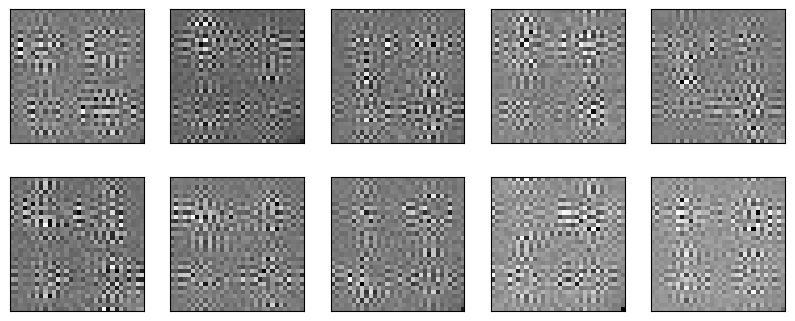

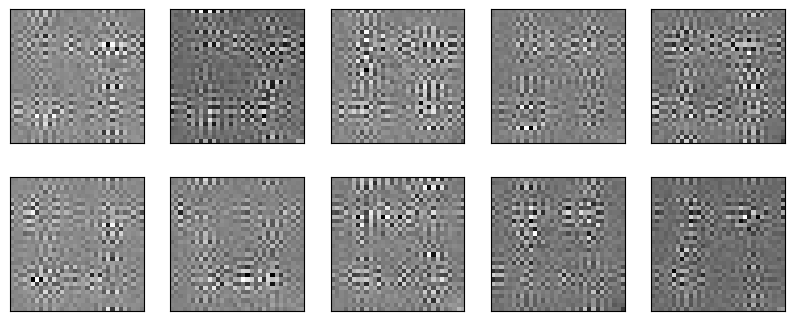

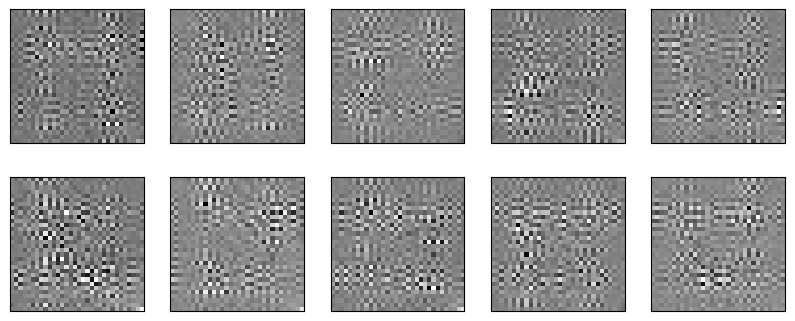

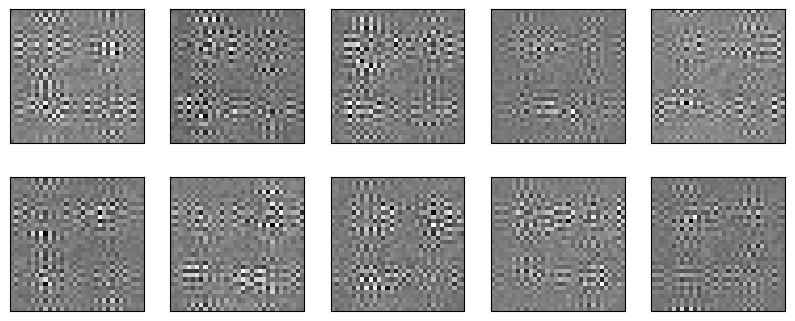

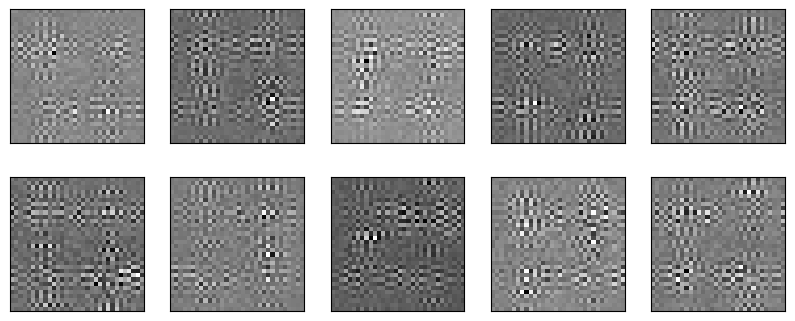

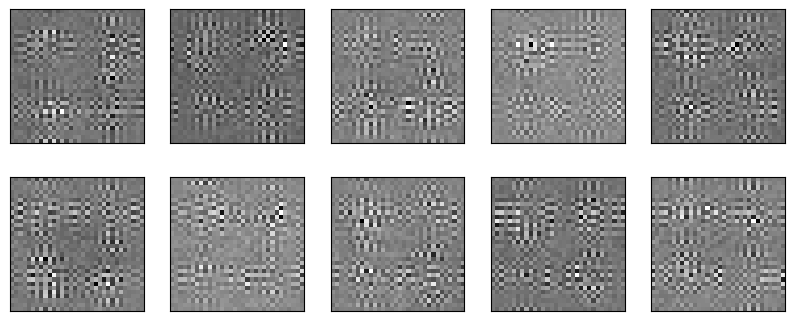

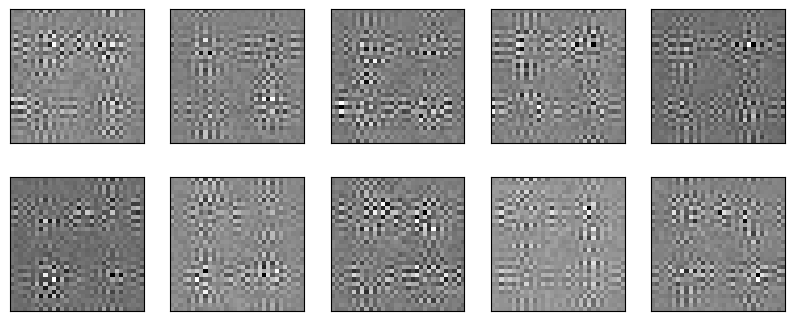

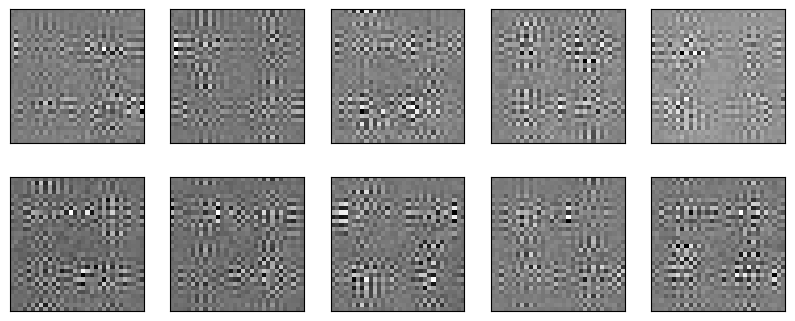

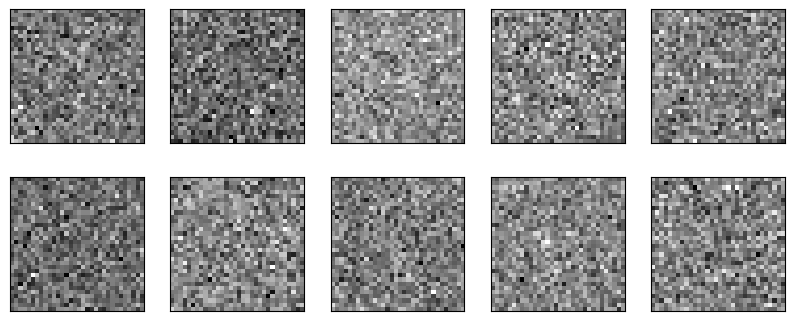

In [42]:
if __name__ == "__main__":
    train_waveguide_diffusion(dataset)